<div class='center'>
<img src='images/seattlehouses.jpg' style='width:800px;'/>
</div>

---

# Doug and the Data Diggers

Authors: Jakub Rybicki, Chris O'Malley, Doug Mill

---

## Overview

Our task is to build an inferential linear regression model. Our model will help our stakeholder understand King County home valuations better. We will follow the assumptions of linear regression which are linearity, independence, normality, and homoscedasticity. We will also strive to have a high R^2 value, signaling that our parameters are explaining much of the total variance in house sales.

## Business Understanding

Our stakeholder is an out-of-town real estate agency interested in opening an office in King County. The county seat is Seattle.

We are acting as a consultant for our stakeholder to determine key factors in evaluating a home in King County. We want to provide our client with the math and reasoning behind local home valuations. We will discuss the important features that affect a valuation based on analysis of previous home sales in the area. We will take a look at factors such as home size & space, school district in which the home is located, upgrades & amenities, and local market conditions.

Our stakeholder will be able to evaluate the Seattle and King County real estate market by understanding the key variables that affect price from our analysis.

## Data Understanding

Our original data set includes info about King County homes that sold between May 2nd, 2014 to May 24th, 2015. The target variable is price. We removed properties that were outside of three standard deviations of the mean price. This left us with homes with a price under $1.65M. We also removed typos. That took us from 21597 entries to 21280. We then incorporated 2015 School GIS data from kingcounty.gov in order to create our 'District' variable. The District variable includes the school district that the home is located in. There are 18 school districts in King County. We cleaned the original data set and merged it with the outside data in order to create our cleaned dataset, known as 'KingSchool.csv'. It can be found in the data folder.

### *Loading our data*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Data Preparation

For data preparation, we formatted many columns. We later decided we didn't need to use many of them. We ended up eliminating samples where the price was outside of 3 standard deviations of the mean price. We then found a typo and removed it. This is how we cleaned the data from the dataset that was included which was kc_house_data.csv. 

We incorporated 2015 School GIS data from the kingcounty.gov website. We then merged it with kc_house_data.csv on 4 different keys; 'id', 'lat', 'long', and 'zipcode'. This plotted the entries against district lines, and formed a column in which each entry was classified by the district that it was located in. There are 18 school districts in King County; Mercer Island, Bellevue, Seattle, Lake Washington, Vashon Island, Issaquah, Shoreline, Northshore, Snoqualmie Valley, Riverview, Highline, Renton, Skykomish, Enumclaw, Tahoma, Tukwila, Kent, and Federal Way.

Since district contained 18 categories, we changed it into dummy variables. By using get_dummies, District was transformed into 18 seperate variables. Each variable contains a 0 or 1. 0 signals that the house was not located in that district while 1 signals that it is present in that district.

We picked which columns that we wanted to focus on originally from a heatmap of correlations. We ran train test splits for every single model that we did. We also made sure to run StandardScaler on every single model we did in order to scale them.

In [2]:
df  = pd.read_csv('data/KingSchool.csv')

In [3]:
categoricals = ['District']
dummies = pd.get_dummies(df[categoricals], prefix=categoricals, drop_first=True)
df = df.drop(categoricals, axis=1)
df = pd.concat([df, dummies], axis=1)

In [4]:
df.drop(['date'],axis=1,inplace=True)
df = df.astype(np.float64)
df['District_FEDERAL_WAY'] = df['District_FEDERAL WAY']
df['District_LAKE_WASHINGTON'] = df['District_LAKE WASHINGTON']
df['District_MERCER_ISLAND'] = df['District_MERCER ISLAND']
df['District_SNOQUALMIE_VALLEY'] = df['District_SNOQUALMIE VALLEY']
df['District_VASHON_ISLAND'] = df['District_VASHON ISLAND']
df.drop(['District_FEDERAL WAY','District_LAKE WASHINGTON','District_MERCER ISLAND',
                         'District_SNOQUALMIE VALLEY','District_VASHON ISLAND'],axis=1,inplace=True)

In [5]:
df_dummies = ['District_BELLEVUE','District_ENUMCLAW','District_FEDERAL_WAY','District_HIGHLINE',
                         'District_ISSAQUAH','District_KENT','District_LAKE_WASHINGTON','District_MERCER_ISLAND',
                         'District_NORTHSHORE','District_RENTON','District_RIVERVIEW','District_SEATTLE',
                         'District_SHORELINE','District_SKYKOMISH','District_SNOQUALMIE_VALLEY','District_TAHOMA',
                         'District_TUKWILA','District_VASHON_ISLAND']

An already cleaned kc_house_data.csv was used to extract school data and map using ARCGIS rendering the following formatting obsolete, however it will still be listed for clarity.

### *Column formatting & dealing with missing values*

In [6]:
# Converting Grade to Numeric
# df['grade'] = df['grade'].str.slice(0,2).str.strip()
# df['grade'] = df['grade'].astype(np.int64)

In [7]:
# Converting View to Numeric
# df['view'].fillna('NONE', inplace=True)
# df['view'].replace('NONE', '0', inplace=True)
# df['view'].replace('FAIR', '1', inplace=True)
# df['view'].replace('AVERAGE', '2', inplace=True)
# df['view'].replace('GOOD', '3', inplace=True)
# df['view'].replace('EXCELLENT', '4', inplace=True)
# df['view'] = df['view'].astype(np.int64)

### *Dropping outliers*

In [8]:
#Dropping outliers
# price_mean = np.mean(df['price'])
# cut_off = np.std(df['price']) * 3
# df.drop(df[df['price'] > price_mean + cut_off].index, inplace = True)
# df.drop(df[df['price'] < price_mean - cut_off].index, inplace = True)

### *Presentation Charting*

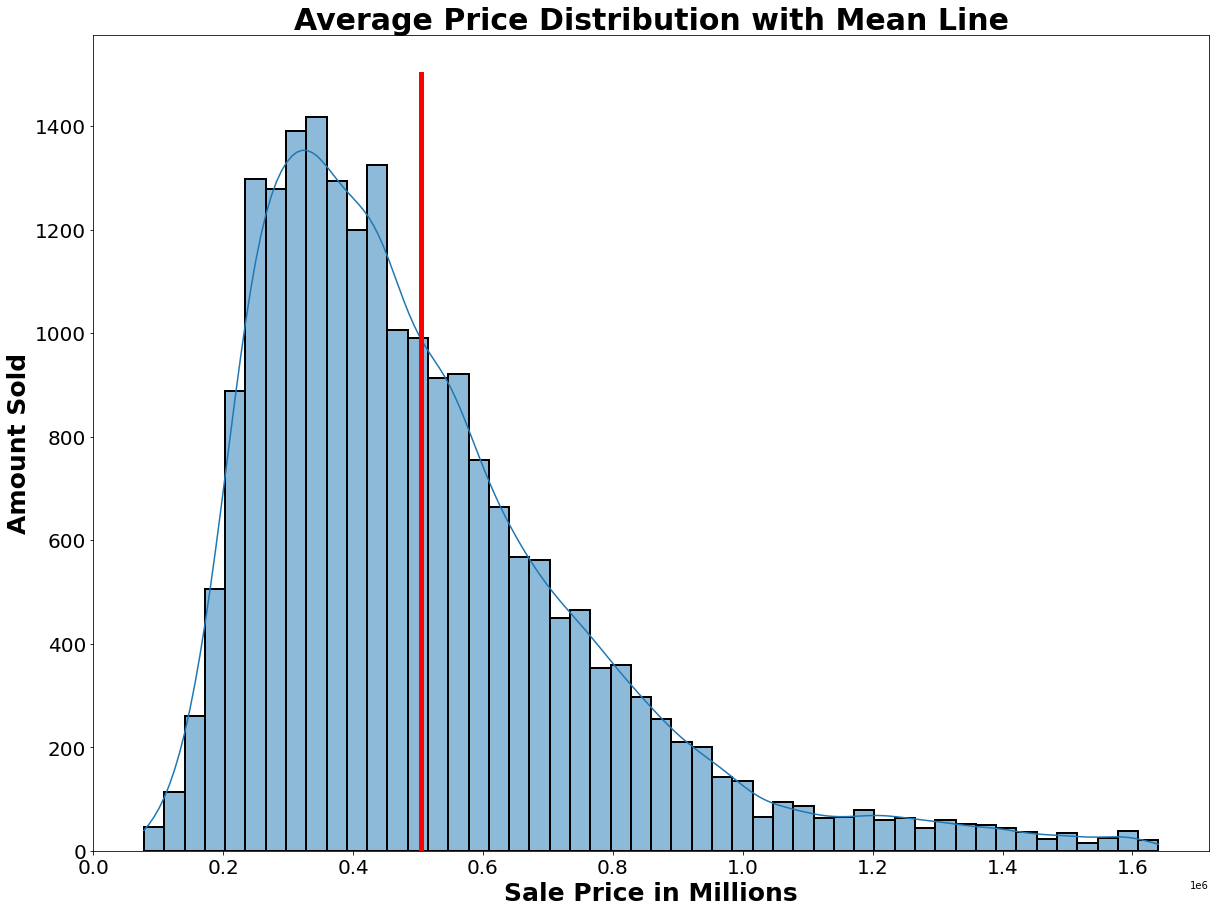

In [9]:
fig, ax = plt.subplots(figsize=(20,15))
sns.histplot(df['price'], ax=ax, bins=50, kde=True, linewidth=2)
plt.plot([df['mean_price'], df['mean_price']], [0, 1500], linewidth=5, color='red')
plt.title('Average Price Distribution with Mean Line', fontsize=30, fontweight='bold')
plt.xlabel('Sale Price in Millions', fontsize=25, fontweight='bold')
plt.xticks(fontsize=20)
plt.ylabel('Amount Sold', fontsize=25, fontweight='bold')
plt.yticks(fontsize=20);

<ipython-input-96-b51d2fa0faa4>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%']);


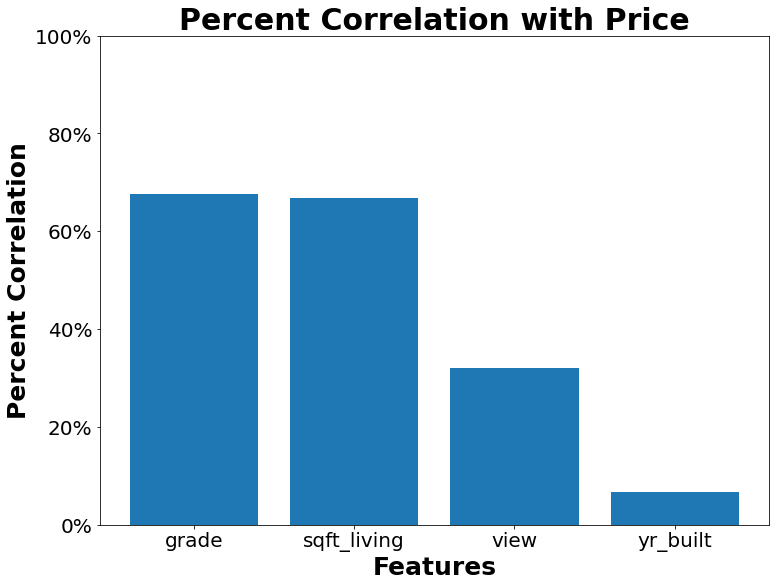

In [96]:
fig, ax = plt.subplots(figsize=(12, 9))
df_corrs = df.corr().abs()['price'].sort_values(ascending=False)
df_corrs = pd.Series(df_corrs[['grade', 'sqft_living', 'view', 'yr_built']])
ax.bar(df_corrs.index, df_corrs.values)
plt.ylim(0, 1.0)
plt.title('Percent Correlation with Price', fontsize=30, fontweight='bold')
plt.xlabel('Features', fontsize=25, fontweight='bold')
plt.xticks( fontsize=20)
plt.ylabel('Percent Correlation', fontsize=25, fontweight='bold')
plt.yticks(fontsize=20)
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%']);

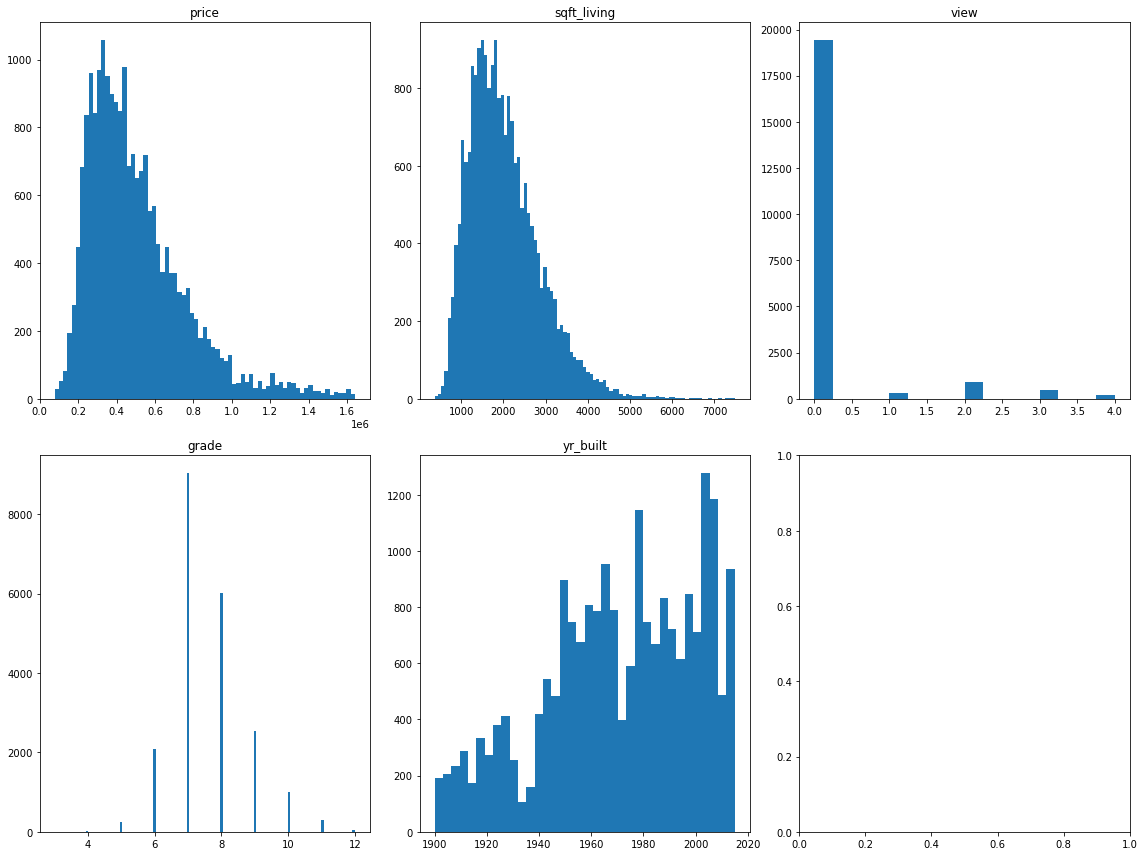

In [10]:
df_no_district = df[['price', 'sqft_living', 'view', 'grade', 'yr_built']]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,12))

columns = df_no_district.columns

for col, ax in zip(columns, axes.flatten()):
    ax.hist(df_no_district[col].dropna(), bins='auto')
    ax.set_title(col)
    
fig.tight_layout()

## Modeling

We created 6 models. Baseline model, First model, Good model, Great model, Awesome model, and Amazing model.
In the end, we decided to go with Great model as our Final model. 

Our Final model, known as "Great Model" has the follow predictors:
1. Square feet living
2. School Districts
3. Building Grade

We decided Great Model is adequate with an R-squared value of .72 with only 3 predictors. The simplicity of it makes it easy to understand and use while also explaining such a high amount of the variance in price.

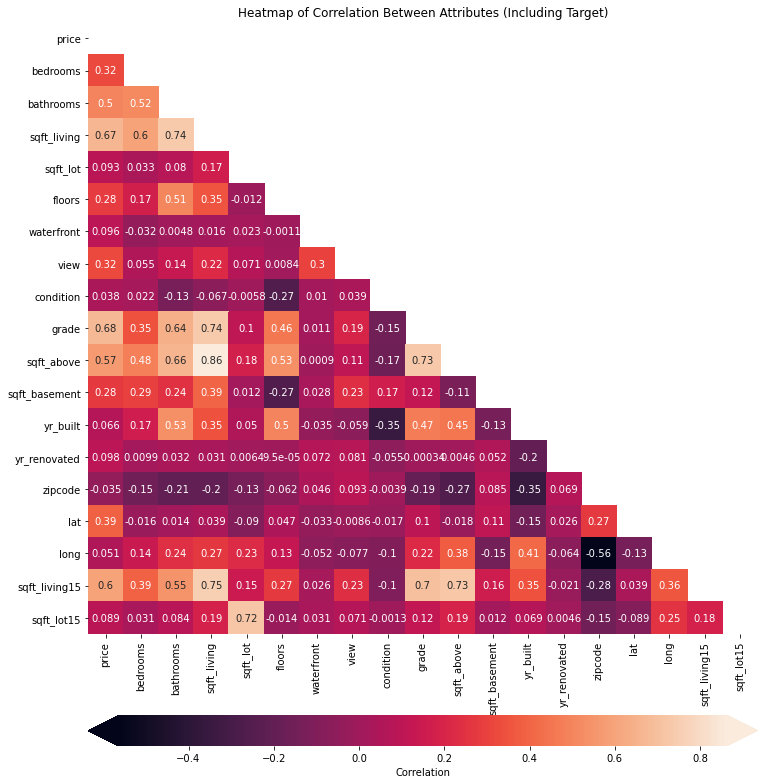

In [11]:
corr = df.iloc[:, 2:21].corr()
# Set up figure and axes
fig, ax = plt.subplots(figsize=(12, 15))
# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .1, "extend": "both"},
    annot_kws={"fontsize":10}
)
# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

### *Helper Functions*

In [12]:
def linearity_plot(x, y):
    x = pd.DataFrame(x)
    y = pd.DataFrame(y)
    cols = 1
    if x.shape[1] % 2 == 0:
        cols = 2
    elif x.shape[1] < 2:
        cols = 1
    else:
        cols = 3
    rows = 1
    if x.shape[1] // cols == 0:
        rows = 1
    elif x.shape[1] % cols > 0:
        rows = x.shape[1] // cols + 1
    else:
        rows = rows = x.shape[1] // cols 
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(16,10), squeeze=False)
    fig.set_tight_layout(True)
    for index, col in enumerate(x.columns):
        ax = axes[index//cols][index%cols]
        ax.scatter(x[col], y, alpha=0.2)
        ax.set_xlabel(col, fontsize=20)
        ax.set_ylabel("Listing price", fontsize=20)

In [13]:
def train_lr_randomly(data, sample_pt=None, ntimes=500):
    '''
    Takes in features & targets from `data` to train a linear regression with a
    random sample `ntimes`. It then returns a list of R2 scores, RMSEs, and the 
    predictions from a provided data point of features `sample_pt`.
    '''
    # To save all of our predictions
    r2 = []
    rmse = []
    # Only return predictions if there is something to predict (sample_pt given)
    point_preds = [] if (sample_pt is not None) else None

    # We'll repeat this little experiment to see how the model does
    for i in range(ntimes):
        # Creating a random sample of data to train on
        df_sample = data.sample(5000, replace=True)
        y = df_sample.price
        X = df_sample.drop('price', axis=1)

        # Our linear regression model about to be trained
        lr = LinearRegression()
        lr.fit(X, y)

        # Making predictions & evaluating on the data we used to train the model
        y_hat = lr.predict(X)
        rmse.append(np.sqrt(mean_squared_error(y, y_hat)))
        r2.append(lr.score(X, y))

        # Making a prediction on the one point the model definitely never saw
        if sample_pt is not None:
            y_hat_pt = lr.predict(sample_pt)
            # Getting just the single point to add into list
            point_preds.append(y_hat_pt[0])
    
    return r2, rmse, point_preds

In [14]:
def test_box(formula = df.columns[1:6]):
    sum_df = df[formula]
    sum_sample = sum_df.sample(1)
    sum_sample_price = sum_sample.iloc[0]['price']
    sum_sample_pt = sum_sample.drop('price', axis=1)
    print(sum_sample_price)
    # Show my random sample off
    print(f'Price of sample: ${sum_sample_price}')    
    
    # Run 100 linear regression trainings on some random data from df and compare
    # it with the random sample point
    r2_sum, rmse_sum, pt_preds_sum = train_lr_randomly(
                                                            data=sum_df, 
                                                            sample_pt=sum_sample_pt,
                                                            ntimes=500                            
    )
    
    ax = sns.boxplot(x=pt_preds_sum);
    ax = sns.swarmplot(x=pt_preds_sum, color='orange', ax=ax)
    ax.set_title(f'Predicting Sample Pt Price: ${sum_sample_price:,.2f}');

### Baseline Model

Our baseline model takes the mean price of the whole dataset. It is a horizontal line which sits at the mean price.

In [15]:
baseline_y = df['price']
baseline_X = df.drop(['price'], axis=1)

In [16]:
baseline_X_train, baseline_X_test, baseline_y_train, baseline_y_test = train_test_split(baseline_X, baseline_y, random_state=42)

In [17]:
scaler = StandardScaler()
baseline_X_train_scaled = scaler.fit_transform(baseline_X_train)
baseline_X_test_scaled = scaler.fit_transform(baseline_X_test)



In [18]:
print(f'Train Mean: {baseline_y_train.mean()}, Test Mean: {baseline_y_test.mean()}')

Train Mean: 505470.75820802007, Test Mean: 503495.4421052632


In [19]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(baseline_X_train_scaled, baseline_y_train)
dummy_regr.predict(baseline_X_train_scaled)
dummy_regr.score(baseline_X_test_scaled, baseline_y_test)

-5.9275367333189166e-05

In [20]:
baseline_X_train_scaled = pd.DataFrame(baseline_X_train_scaled)
baseline_X_train_scaled.columns = baseline_X.columns
baseline_X_test_scaled = pd.DataFrame(baseline_X_test_scaled)
baseline_X_test_scaled.columns = baseline_X.columns

### *Interpreting the baseline model*

Our baseline model definitely follows the linearity assumption. The distribution of errors is slightly skewed right. Many of the VIF values are above 10 and this indicates that there is high multicollinearity. It passes the homoscedasticity test.

### *Assumptions*

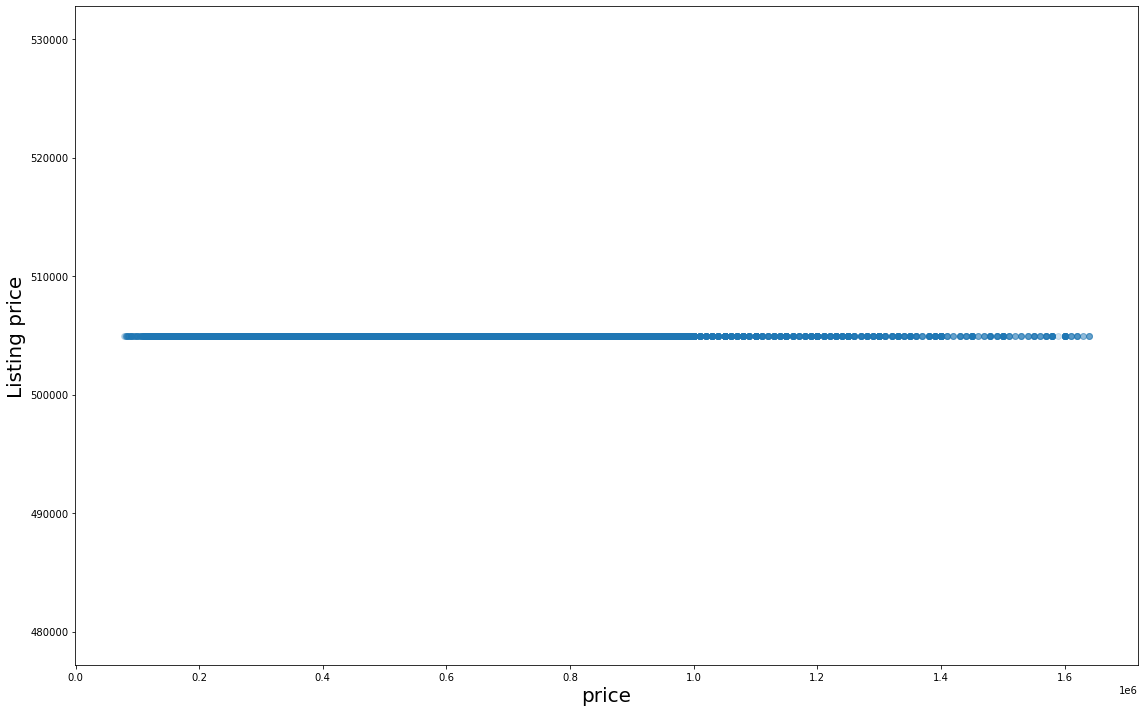

In [21]:
#LINEARITY
df['mean_price']=df['price'].mean()
linearity_plot(df['price'], df['mean_price'])

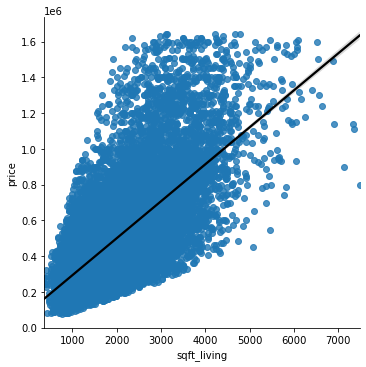

In [22]:
sns.lmplot(x='sqft_living', y='price', data=df, line_kws={'color': 'black'});

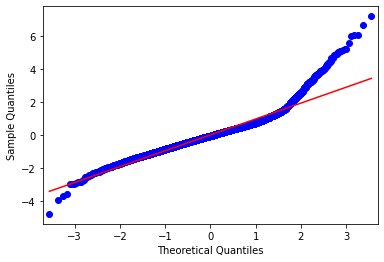

In [23]:
#NORMALITY
# Normal distribution of errors check
baseline_model = LinearRegression()
baseline_model.fit(baseline_X_train_scaled, baseline_y_train)
baseline_model.score(baseline_X_test_scaled, baseline_y_test)
preds = baseline_model.predict(baseline_X_test_scaled)
residuals = (baseline_y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True);

In [24]:
#Checking MULTICOLLINEARITY 
# (VIF NEEDS TO BE <5 ALL CATEGORIES)
vif = [variance_inflation_factor(baseline_X_train_scaled.values, i) for i in range(baseline_X_train_scaled.shape[1])]
pd.Series(vif, index=baseline_X_train_scaled.columns, name="Variance Inflation Factor")

Unnamed: 0                      1.073923
id                              1.043621
bedrooms                        1.765693
bathrooms                       3.271621
sqft_living                   136.811794
sqft_lot                        2.249136
floors                          2.343878
waterfront                      1.145019
view                            1.332147
condition                       1.263405
grade                           3.329488
sqft_above                    115.937208
sqft_basement                  37.289020
yr_built                        2.798273
yr_renovated                    1.365758
zipcode                         4.730191
lat                             9.724322
long                            9.724980
sqft_living15                   3.147801
sqft_lot15                      2.408914
renovated_less_10yrs            1.252801
has_basement                    3.742603
Distance_to_School_ft           1.516060
mean_price                      1.000000
District_BELLEVU

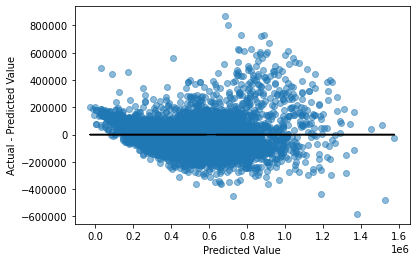

In [27]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()
ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(baseline_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

### *Mass Tests*

402000.0
Price of sample: $402000.0


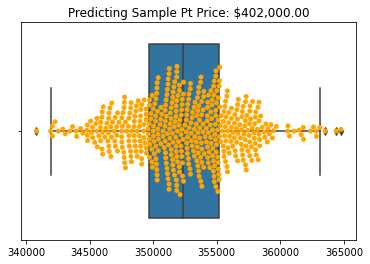

In [28]:
test_box()

### *Dropping Unnecessary Columns*

In [29]:
df.drop(['id','bedrooms','bathrooms','sqft_lot','floors','waterfront','condition','sqft_above','sqft_basement', 'yr_renovated',
                         'zipcode','lat','long','sqft_living15','sqft_lot15','renovated_less_10yrs',
                         'has_basement','Distance_to_School_ft','mean_price'], axis=1,inplace=True)

### First Model: Square Feet Living & Price

Our first model includes Square Feet Living plotted against Price.

In [30]:
first_y = df["price"]
first_formula = ['sqft_living']
first_full_formula = ['price'] + first_formula
first_X = df[first_formula]

In [31]:
first_X_train, first_X_test, first_y_train, first_y_test = train_test_split(first_X, first_y, random_state=42)

In [32]:
scaler = StandardScaler()
first_X_train_scaled = scaler.fit_transform(first_X_train)
first_X_test_scaled = scaler.fit_transform(first_X_test)

In [33]:
first_model = LinearRegression()

# Fit the model on X_train_final and y_train
first_model.fit(first_X_train_scaled, first_y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
first_model.score(first_X_test_scaled, first_y_test)

0.44340198198180003

In [34]:
print(f'Train RMSE: {mean_squared_error(first_y_train, first_model.predict(first_X_train_scaled), squared=False)}')
print(f'Test RMSE: {mean_squared_error(first_y_test, first_model.predict(first_X_test_scaled), squared=False)}')

Train RMSE: 193820.19648495235
Test RMSE: 191412.50411807414


In [35]:
sm.OLS(first_y_train, sm.add_constant(first_X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 1.281e+04
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:33:23   Log-Likelihood:            -2.1695e+05
No. Observations:               15960   AIC:                         4.339e+05
Df Residuals:                   15958   BIC:                         4.339e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.629e+04   4008.335     21.528      0.000    7.84e+04    9.41e+04
sqft_living   206.6365      1.825    113.198      0.000     203.058     210.215
==============================================================================
Omnibus:                     2675.571   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5713.288
Skew:                           0.993   Prob(JB):                         0.00
Kurtosis:                       5.155   Cond. No.                     5.74e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
first_X_train_scaled = pd.DataFrame(first_X_train_scaled)
first_X_train_scaled.columns = first_X.columns
first_X_test_scaled = pd.DataFrame(first_X_test_scaled)
first_X_test_scaled.columns = first_X.columns

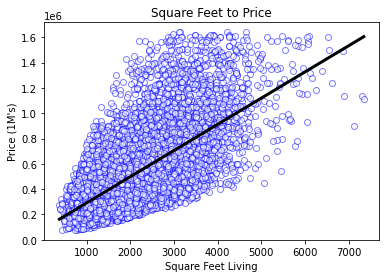

In [37]:
fig, ax = plt.subplots()
ax.scatter(first_X_train[first_formula], first_y_train, alpha=0.5, color ='white', edgecolor='blue')
ax.set_xlabel('Square Feet Living')
ax.set_ylabel("Price (1M's)")
ax.set_title('Square Feet to Price')
plt.plot(np.unique(first_X_train['sqft_living']), np.poly1d(np.polyfit(first_X_train['sqft_living'], first_y_train, 1))
         (np.unique(first_X_train['sqft_living'])),linewidth=3.0,color='black');


### *Interpreting the first model*

Square Feet Living drives up Price. It has an R-squared of .445. It explains 44.5% of the variance in price by itself. It is the most correlated variable and individually most significant in our findings. Our first model definitely follows the linearity assumption. The distribution of errors is very slightly heavy on the tails. Multicollinearity is not applicable for one predictor. It passes the homoscedasticity test.

### *Assumptions*

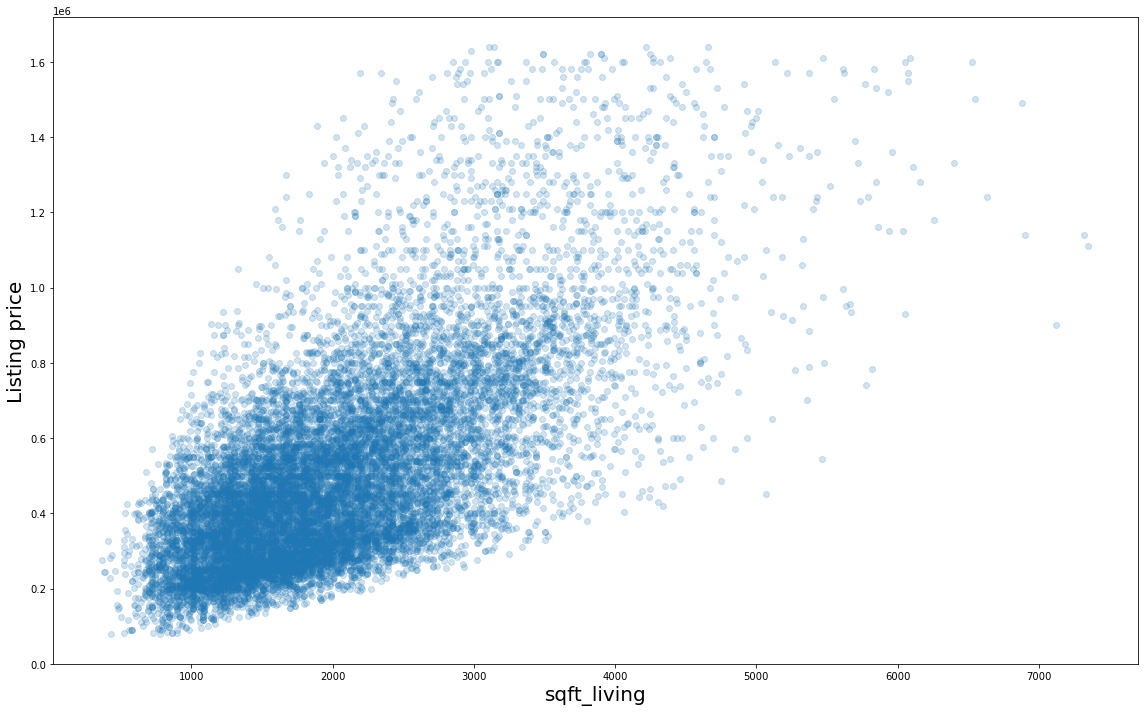

In [38]:
#LINEARITY
linearity_plot(first_X_train, first_y_train)

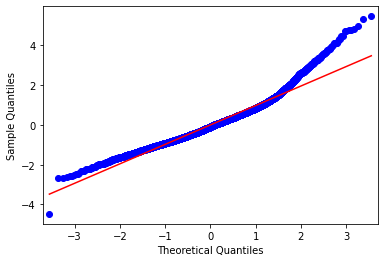

In [39]:
#NORMALITY
import scipy.stats as stats
preds_1st = first_model.predict(first_X_test_scaled)
residuals = (first_y_test - preds_1st)
sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True);

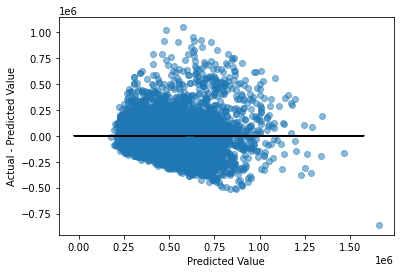

In [41]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()
ax.scatter(preds_1st, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(first_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

452500.0
Price of sample: $452500.0


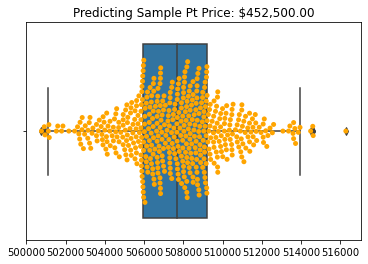

In [42]:
test_box(first_full_formula)

### Good Model: Square Feet Living and School District

For the good model, we have 2 predictors. Those predictors are square feet living and school district. Our school district variable consists of the 18 districts located in King County. Those districts are Bellevue, Enumclaw, Federal Way, Highline, Issaquah, Kent, Lake Washington, Mercer Island, Northshore, Renton, Riverview, Seattle, Shoreline, Skykomish, Snoqualmie Valley, Tahoma, Tukwila, Vashon Island.

In [43]:
good_y = df["price"]
good_formula = first_formula + ['District_BELLEVUE','District_ENUMCLAW','District_FEDERAL_WAY',
                 'District_HIGHLINE','District_ISSAQUAH','District_KENT','District_LAKE_WASHINGTON','District_MERCER_ISLAND',
                 'District_NORTHSHORE','District_RENTON','District_RIVERVIEW','District_SEATTLE','District_SHORELINE',
                 'District_SKYKOMISH','District_SNOQUALMIE_VALLEY','District_TAHOMA','District_TUKWILA',
                 'District_VASHON_ISLAND']
good_full_formula = ['price'] + good_formula
good_X = df[good_formula]

In [44]:
good_X_train, good_X_test, good_y_train, good_y_test = train_test_split(good_X, good_y, random_state=42)

In [45]:
scaler = StandardScaler()
good_X_train_scaled = scaler.fit_transform(good_X_train)
good_X_test_scaled = scaler.fit_transform(good_X_test)



In [46]:
good_model = LinearRegression()

# Fit the model on X_train_final and y_train
good_model.fit(good_X_train_scaled, good_y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
good_model.score(good_X_test_scaled, good_y_test)

0.679687962204343

In [47]:
print(f'Train RMSE: {mean_squared_error(good_y_train, good_model.predict(good_X_train_scaled), squared=False)}')
print(f'Test RMSE: {mean_squared_error(good_y_test, good_model.predict(good_X_test_scaled), squared=False)}')

Train RMSE: 146504.89668165264
Test RMSE: 145206.51665712724


In [48]:
sm.OLS(good_y_train, sm.add_constant(good_X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     1808.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:33:28   Log-Likelihood:            -2.1249e+05
No. Observations:               15960   AIC:                         4.250e+05
Df Residuals:                   15940   BIC:                         4.252e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -1.01e+05   7164.629    -14.103      0.000   -1.15e+05    -8.7e+04
sqft_living                  200.1816      1.484    134.910      0.000     197.273     203.090
District_BELLEVUE             3.8e+05   8303.740     45.762      0.000    3.64e+05    3.96e+05
District_ENUMCLAW           5.535e+04   1.21e+04      4.556      0.000    3.15e+04    7.92e+04
District_FEDERAL_WAY        3927.4677   8145.181      0.482      0.630    -1.2e+04    1.99e+04
District_HIGHLINE           7.912e+04   8306.811      9.525      0.000    6.28e+04    9.54e+04
District_ISSAQUAH           2.388e+05   7892.348     30.254      0.000    2.23e+05    2.54e+05
District_KENT               2.094e+04   7893.004      2.652      0.008    5464.877    3.64e+04
District_LAKE_WASHINGTON    2.634e+05   7479.598     35.212      0.000    2.49e+05    2.78e+05
District_MERCER_ISLAND      5.481e+05   1.25e+04     43.997      0.000    5.24e+05    5.73e+05
District_NORTHSHORE         1.688e+05   8544.068     19.762      0.000    1.52e+05    1.86e+05
District_RENTON             7.979e+04   8129.760      9.814      0.000    6.39e+04    9.57e+04
District_RIVERVIEW          1.107e+05   1.17e+04      9.483      0.000    8.78e+04    1.34e+05
District_SEATTLE            3.087e+05   6864.611     44.972      0.000    2.95e+05    3.22e+05
District_SHORELINE          1.552e+05   8755.503     17.723      0.000    1.38e+05    1.72e+05
District_SKYKOMISH          5.689e+04   4.68e+04      1.215      0.224   -3.49e+04    1.49e+05
District_SNOQUALMIE_VALLEY  1.237e+05   9557.007     12.939      0.000    1.05e+05    1.42e+05
District_TAHOMA             4.697e+04   9511.625      4.938      0.000    2.83e+04    6.56e+04
District_TUKWILA            1.891e+04    1.8e+04      1.048      0.295   -1.65e+04    5.43e+04
District_VASHON_ISLAND      2.055e+05   1.75e+04     11.767      0.000    1.71e+05     2.4e+05
==============================================================================
Omnibus:                     3949.092   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17464.062
Skew:                           1.147   Prob(JB):                         0.00
Kurtosis:                       7.582   Cond. No.                     8.91e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
good_X_train_scaled = pd.DataFrame(good_X_train_scaled)
good_X_train_scaled.columns = good_X.columns
good_X_test_scaled = pd.DataFrame(good_X_test_scaled)
good_X_test_scaled.columns = good_X.columns

### *Interpreting the model*

Good model has an R-squared of .683. Square feet living combined with District explains 68.3% of the variance in price. The inclusion of District raised our R-squared from .44 to .68, for an increase of .24. Our good model definitely follows the linearity assumption. Square feet living follows linearity, and district is linear by definition as a categorical variable. The distribution of errors is skewed right. Good model has low multicollinearity in general, with all VIF below 5 except for District_SEATTLE at 7. It passes the homoscedasticity test.

### *Assumptions*

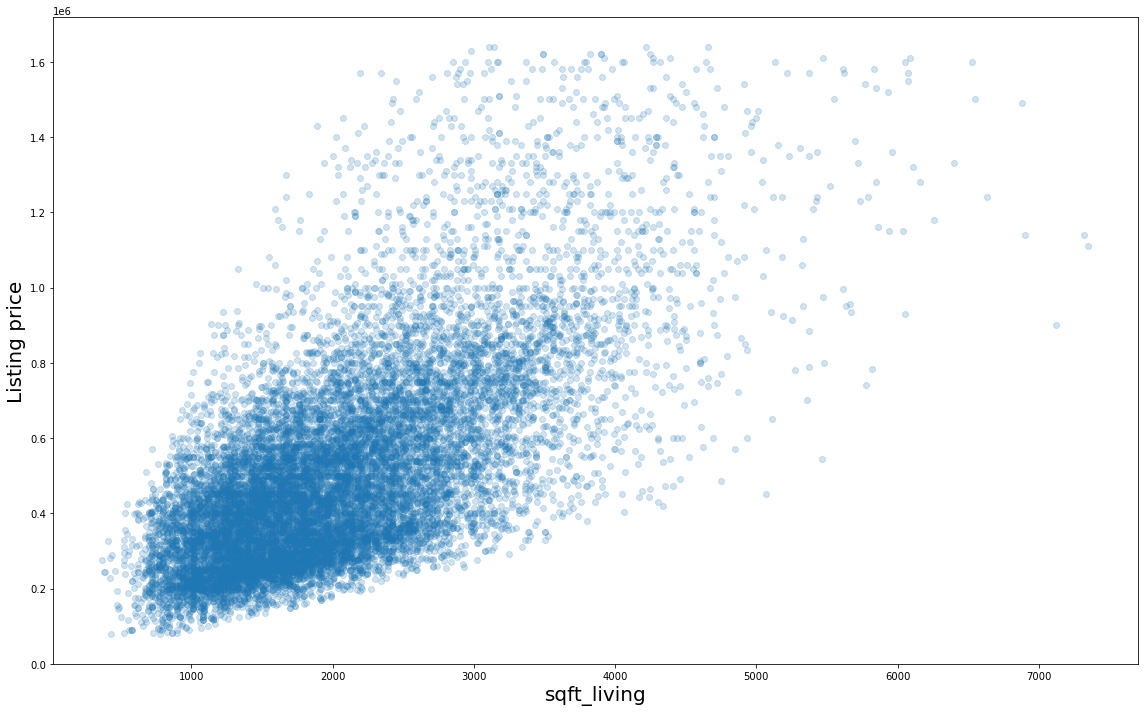

In [50]:
linearity_plot(good_X_train['sqft_living'], good_y_train)

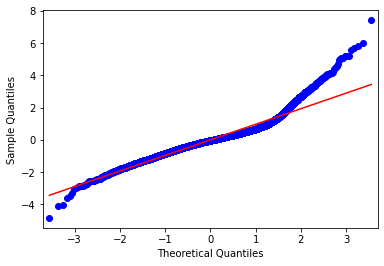

In [51]:
#NORMALITY
good_X_test_scaled = pd.DataFrame(good_X_test_scaled)
preds_good = good_model.predict(good_X_test_scaled)
residuals = (good_y_test - preds_good)
sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True);

In [52]:
#Checking MULTICOLLINEARITY 
# (VIF NEEDS TO BE <5 ALL CATEGORIES)
vif = [variance_inflation_factor(good_X_train_scaled.values, i) for i in range(good_X_train_scaled.shape[1])]
pd.Series(vif, index=good_X_train_scaled.columns, name="Variance Inflation Factor")

sqft_living                   1.155113
District_BELLEVUE             2.513041
District_ENUMCLAW             1.390043
District_FEDERAL_WAY          2.649096
District_HIGHLINE             2.509142
District_ISSAQUAH             3.135146
District_KENT                 2.964030
District_LAKE_WASHINGTON      3.880098
District_MERCER_ISLAND        1.383880
District_NORTHSHORE           2.319963
District_RENTON               2.666302
District_RIVERVIEW            1.436949
District_SEATTLE              7.534610
District_SHORELINE            2.171693
District_SKYKOMISH            1.019561
District_SNOQUALMIE_VALLEY    1.834530
District_TAHOMA               1.844965
District_TUKWILA              1.146397
District_VASHON_ISLAND        1.157284
Name: Variance Inflation Factor, dtype: float64

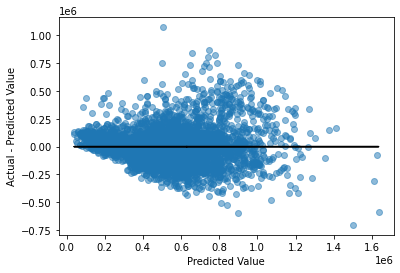

In [53]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()

ax.scatter(preds_good, residuals, alpha=0.5)
ax.plot(preds_good, [0 for i in range(len(good_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

In [54]:
#HOMOSCEDASTICITY BORDERLINE

472000.0
Price of sample: $472000.0


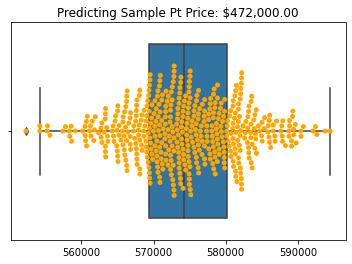

In [55]:
test_box(good_full_formula)

### Great Model: Square feet living, School districts, and Grade

The Great model uses square feet living, school districts, and grade as our predictors.

In [56]:
great_y = df["price"]
great_formula = good_formula + ['grade']
great_full_formula = ['price'] + great_formula
great_X = df[great_formula]

In [57]:
great_X_train, great_X_test, great_y_train, great_y_test = train_test_split(great_X, great_y, random_state=42)

In [58]:
scaler = StandardScaler()
great_X_train_scaled = scaler.fit_transform(great_X_train)
great_X_test_scaled = scaler.fit_transform(great_X_test)

In [59]:
great_model = LinearRegression()

# Fit the model on X_train_final and y_train
great_model.fit(great_X_train_scaled, great_y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
great_model.score(great_X_test_scaled, great_y_test)

0.7171663975173888

In [60]:
print(f'Train RMSE: {mean_squared_error(great_y_train, great_model.predict(great_X_train_scaled), squared=False)}')
print(f'Test RMSE: {mean_squared_error(great_y_test, great_model.predict(great_X_test_scaled), squared=False)}')

Train RMSE: 137070.49516065692
Test RMSE: 136447.31048874996


In [61]:
sm.OLS(great_y_train, sm.add_constant(great_X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     2076.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:33:35   Log-Likelihood:            -2.1143e+05
No. Observations:               15960   AIC:                         4.229e+05
Df Residuals:                   15939   BIC:                         4.231e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -4.987e+05   1.07e+04    -46.583      0.000    -5.2e+05   -4.78e+05
sqft_living                  134.4543      1.957     68.696      0.000     130.618     138.291
District_BELLEVUE           3.601e+05   7780.478     46.282      0.000    3.45e+05    3.75e+05
District_ENUMCLAW           6.508e+04   1.14e+04      5.724      0.000    4.28e+04    8.74e+04
District_FEDERAL_WAY       -3235.9033   7622.382     -0.425      0.671   -1.82e+04    1.17e+04
District_HIGHLINE           9.863e+04   7782.911     12.673      0.000    8.34e+04    1.14e+05
District_ISSAQUAH           2.032e+05   7422.089     27.372      0.000    1.89e+05    2.18e+05
District_KENT               1.824e+04   7385.171      2.469      0.014    3761.031    3.27e+04
District_LAKE_WASHINGTON    2.378e+05   7018.643     33.887      0.000    2.24e+05    2.52e+05
District_MERCER_ISLAND      5.088e+05   1.17e+04     43.543      0.000    4.86e+05    5.32e+05
District_NORTHSHORE         1.537e+05   8000.399     19.216      0.000    1.38e+05    1.69e+05
District_RENTON             9.294e+04   7611.474     12.210      0.000     7.8e+04    1.08e+05
District_RIVERVIEW          1.211e+05   1.09e+04     11.087      0.000    9.97e+04    1.43e+05
District_SEATTLE            2.974e+05   6427.145     46.273      0.000    2.85e+05     3.1e+05
District_SHORELINE          1.625e+05   8193.371     19.831      0.000    1.46e+05    1.79e+05
District_SKYKOMISH          9.281e+04   4.38e+04      2.118      0.034    6928.252    1.79e+05
District_SNOQUALMIE_VALLEY   1.26e+05   8941.986     14.092      0.000    1.08e+05    1.44e+05
District_TAHOMA             4.614e+04   8899.406      5.185      0.000    2.87e+04    6.36e+04
District_TUKWILA            4.293e+04   1.69e+04      2.541      0.011    9812.714     7.6e+04
District_VASHON_ISLAND      2.087e+05   1.63e+04     12.777      0.000    1.77e+05    2.41e+05
grade                       7.109e+04   1492.201     47.641      0.000    6.82e+04     7.4e+04
==============================================================================
Omnibus:                     4227.521   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17655.118
Skew:                           1.252   Prob(JB):                         0.00
Kurtosis:                       7.504   Cond. No.                     8.91e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
great_X_train_scaled = pd.DataFrame(great_X_train_scaled)
great_X_train_scaled.columns = great_X.columns
great_X_test_scaled = pd.DataFrame(great_X_test_scaled)
great_X_test_scaled.columns = great_X.columns

### *Interpreting the model*

Great model has an R-squared of .723. Square feet living, District, and Grade explains 72.3% of the variance in price. This is our first model which crosses the .7 R-squared threshold. The inclusion of Grade raised our R-squared from .68 to .72, for an increase of .04. Our great model definitely follows the linearity assumption, given that Districts are linear by definition, and Grade is also linear. The distribution of errors is unfortunately skewed right. Great model has low multicollinearity in general, with all VIF below 5 except for District_SEATTLE at 7. It passes the homoscedasticity test.

### *Assumptions*

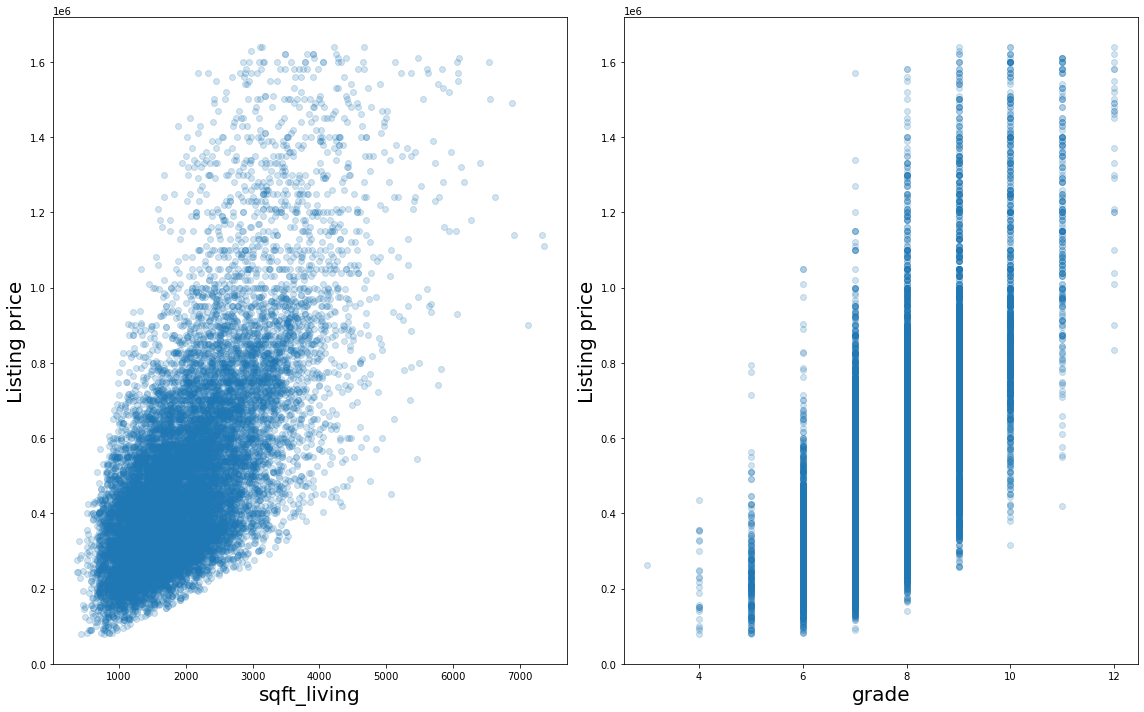

In [63]:
# Linearity
linearity_plot(great_X_train[['sqft_living', 'grade']], great_y_train)

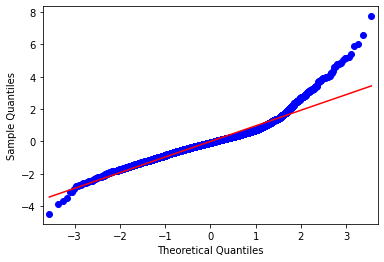

In [64]:
#NORMALITY
great_X_test_scaled = pd.DataFrame(great_X_test_scaled)
preds_great = great_model.predict(great_X_test_scaled)
residuals = (great_y_test - preds_great)
sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True);

In [65]:
#Checking MULTICOLLINEARITY 
# (VIF NEEDS TO BE <5 ALL CATEGORIES)
vif = [variance_inflation_factor(great_X_train_scaled.values, i) for i in range(great_X_train_scaled.shape[1])]
pd.Series(vif, index=great_X_train_scaled.columns, name="Variance Inflation Factor")

sqft_living                   2.295861
District_BELLEVUE             2.520308
District_ENUMCLAW             1.390491
District_FEDERAL_WAY          2.650127
District_HIGHLINE             2.516111
District_ISSAQUAH             3.167282
District_KENT                 2.964204
District_LAKE_WASHINGTON      3.902847
District_MERCER_ISLAND        1.390814
District_NORTHSHORE           2.323615
District_RENTON               2.669811
District_RIVERVIEW            1.437524
District_SEATTLE              7.544912
District_SHORELINE            2.172454
District_SKYKOMISH            1.019863
District_SNOQUALMIE_VALLEY    1.834586
District_TAHOMA               1.844972
District_TUKWILA              1.147418
District_VASHON_ISLAND        1.157304
grade                         2.365869
Name: Variance Inflation Factor, dtype: float64

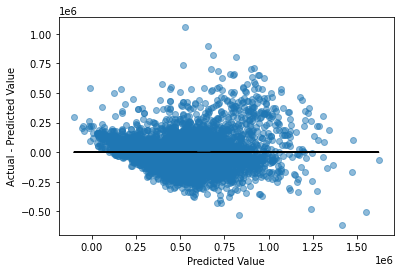

In [66]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()

ax.scatter(preds_great, residuals, alpha=0.5)
ax.plot(preds_great, [0 for i in range(len(great_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

605000.0
Price of sample: $605000.0


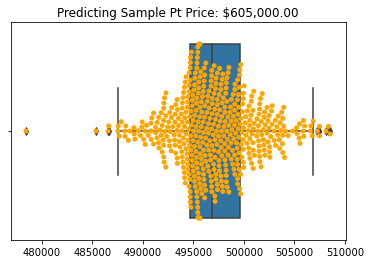

In [68]:
test_box(great_full_formula)

### Awesome Model: sqft_living, school districts, grade, year built

Awesome model includes square feet living, school districts, grade, and year built as predictors.

In [69]:
awesome_y = df["price"]
awesome_formula = great_formula + ['yr_built']
awesome_full_formula = ['price'] + awesome_formula
awesome_X = df[awesome_formula]

In [70]:
awesome_X_train, awesome_X_test, awesome_y_train, awesome_y_test = train_test_split(awesome_X, awesome_y, random_state=42)

In [71]:
scaler = StandardScaler()
awesome_X_train_scaled = scaler.fit_transform(awesome_X_train)
awesome_X_test_scaled = scaler.fit_transform(awesome_X_test)

In [72]:
awesome_model = LinearRegression()

# Fit the model on X_train_final and y_train
awesome_model.fit(awesome_X_train_scaled, awesome_y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
awesome_model.score(awesome_X_test_scaled, awesome_y_test)

0.7369289902936133

In [73]:
print(f'Train RMSE: {mean_squared_error(awesome_y_train, awesome_model.predict(awesome_X_train_scaled), squared=False)}')
print(f'Test RMSE: {mean_squared_error(awesome_y_test, awesome_model.predict(awesome_X_test_scaled), squared=False)}')

Train RMSE: 132161.5994675322
Test RMSE: 131593.96508963977


In [74]:
sm.OLS(awesome_y_train, sm.add_constant(awesome_X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     2184.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:33:41   Log-Likelihood:            -2.1084e+05
No. Observations:               15960   AIC:                         4.217e+05
Df Residuals:                   15938   BIC:                         4.219e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       2.529e+06   8.78e+04     28.806      0.000    2.36e+06     2.7e+06
sqft_living                  128.4031      1.895     67.750      0.000     124.688     132.118
District_BELLEVUE            3.29e+05   7555.335     43.545      0.000    3.14e+05    3.44e+05
District_ENUMCLAW           5.452e+04    1.1e+04      4.972      0.000     3.3e+04     7.6e+04
District_FEDERAL_WAY       -1.095e+04   7352.992     -1.490      0.136   -2.54e+04    3459.959
District_HIGHLINE           7.288e+04   7540.965      9.665      0.000    5.81e+04    8.77e+04
District_ISSAQUAH           1.988e+05   7157.610     27.773      0.000    1.85e+05    2.13e+05
District_KENT               2.204e+04   7121.752      3.095      0.002    8080.446     3.6e+04
District_LAKE_WASHINGTON    2.309e+05   6770.431     34.108      0.000    2.18e+05    2.44e+05
District_MERCER_ISLAND      4.688e+05   1.13e+04     41.392      0.000    4.47e+05    4.91e+05
District_NORTHSHORE         1.448e+05   7718.412     18.761      0.000     1.3e+05     1.6e+05
District_RENTON             8.472e+04   7342.925     11.538      0.000    7.03e+04    9.91e+04
District_RIVERVIEW          1.317e+05   1.05e+04     12.500      0.000    1.11e+05    1.52e+05
District_SEATTLE            2.528e+05   6328.670     39.950      0.000     2.4e+05    2.65e+05
District_SHORELINE          1.345e+05   7941.162     16.938      0.000    1.19e+05     1.5e+05
District_SKYKOMISH          8.052e+04   4.23e+04      1.906      0.057   -2292.200    1.63e+05
District_SNOQUALMIE_VALLEY  1.355e+05   8626.335     15.706      0.000    1.19e+05    1.52e+05
District_TAHOMA             6.382e+04   8596.053      7.425      0.000     4.7e+04    8.07e+04
District_TUKWILA            1.549e+04   1.63e+04      0.950      0.342   -1.65e+04    4.75e+04
District_VASHON_ISLAND      1.922e+05   1.58e+04     12.197      0.000    1.61e+05    2.23e+05
grade                       9.178e+04   1557.327     58.937      0.000    8.87e+04    9.48e+04
yr_built                   -1599.5993     46.062    -34.727      0.000   -1689.886   -1509.312
==============================================================================
Omnibus:                     3965.974   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16822.010
Skew:                           1.166   Prob(JB):                         0.00
Kurtosis:                       7.457   Cond. No.                     2.43e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.


In [75]:
awesome_X_train_scaled = pd.DataFrame(awesome_X_train_scaled)
awesome_X_train_scaled.columns = awesome_X.columns
awesome_X_test_scaled = pd.DataFrame(awesome_X_test_scaled)
awesome_X_test_scaled.columns = awesome_X.columns

### *Interpreting the model*

Awesome model has an R-squared of .742. Building on Great model, adding yr_built explains 74.2% of the variance in price. The inclusion of yr_built raised our R-squared from .72 to .74, for an increase of .02. Our awesome model mostly follow the linearity assumption, but the linearity of yr_built is vague. The distribution of errors is skewed right. Good model has low multicollinearity in general, with all VIF below 5 except for District_SEATTLE at 7. It passes the homoscedasticity test.

### *Assumptions*

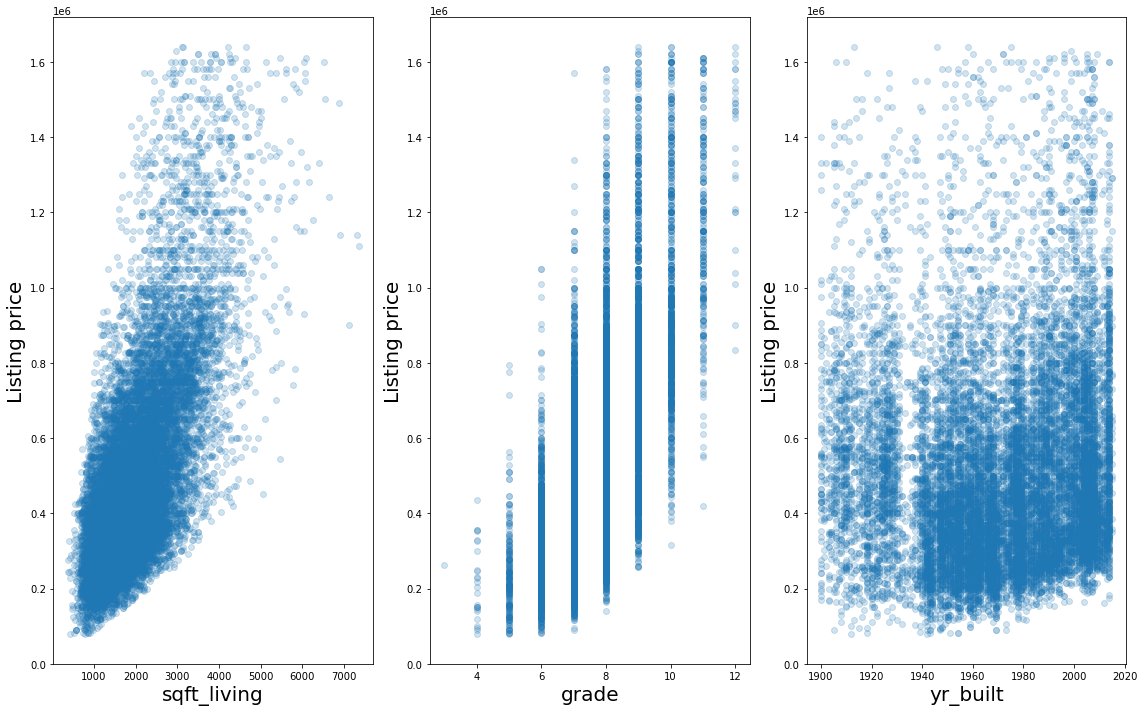

In [76]:
# Linearity
linearity_plot(awesome_X_train[['sqft_living', 'grade', 'yr_built']], awesome_y_train)


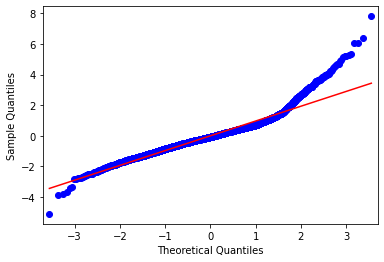

In [77]:
#NORMALITY
awesome_X_test_scaled = pd.DataFrame(awesome_X_test_scaled)
preds_awesome = awesome_model.predict(awesome_X_test_scaled)
residuals = (awesome_y_test - preds_awesome)
sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True);

In [78]:
#Checking MULTICOLLINEARITY 
# (VIF NEEDS TO BE <5 ALL CATEGORIES)
vif = [variance_inflation_factor(awesome_X_train_scaled.values, i) for i in range(awesome_X_train_scaled.shape[1])]
pd.Series(vif, index=awesome_X_train_scaled.columns, name="Variance Inflation Factor")

sqft_living                   2.315433
District_BELLEVUE             2.556223
District_ENUMCLAW             1.391559
District_FEDERAL_WAY          2.652550
District_HIGHLINE             2.540678
District_ISSAQUAH             3.168259
District_KENT                 2.964905
District_LAKE_WASHINGTON      3.906231
District_MERCER_ISLAND        1.405357
District_NORTHSHORE           2.326199
District_RENTON               2.672584
District_RIVERVIEW            1.438735
District_SEATTLE              7.868521
District_SHORELINE            2.195046
District_SKYKOMISH            1.019934
District_SNOQUALMIE_VALLEY    1.836424
District_TAHOMA               1.851467
District_TUKWILA              1.150116
District_VASHON_ISLAND        1.158361
grade                         2.771697
yr_built                      1.649760
Name: Variance Inflation Factor, dtype: float64

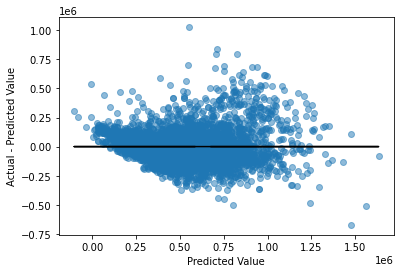

In [79]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()

ax.scatter(preds_awesome, residuals, alpha=0.5)
ax.plot(preds_awesome, [0 for i in range(len(awesome_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

995000.0
Price of sample: $995000.0


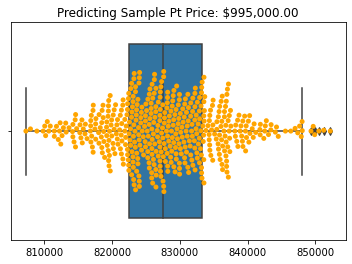

In [80]:
test_box(awesome_full_formula)

### Amazing Model: sqft_living, school districts, grade, year built, view

Amazing model includes square feet living, school districts, grade, year built, and view as predictors.
This makes for a total of 5 predictors.

In [81]:
amazing_y = df["price"]
amazing_formula = awesome_formula + ['view']
amazing_full_formula = ['price'] + amazing_formula
amazing_X = df[amazing_formula]

In [82]:
amazing_X_train, amazing_X_test, amazing_y_train, amazing_y_test = train_test_split(amazing_X, amazing_y, random_state=42)

In [83]:
scaler = StandardScaler()
amazing_X_train_scaled = scaler.fit_transform(amazing_X_train)
amazing_X_test_scaled = scaler.fit_transform(amazing_X_test)

In [84]:
amazing_model = LinearRegression()

# Fit the model on X_train_final and y_train
amazing_model.fit(amazing_X_train_scaled, amazing_y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
amazing_model.score(amazing_X_test_scaled, amazing_y_test)

0.7523975410295785

In [85]:
print(f'Train RMSE: {mean_squared_error(amazing_y_train, amazing_model.predict(amazing_X_train_scaled), squared=False)}')
print(f'Test RMSE: {mean_squared_error(amazing_y_test, amazing_model.predict(amazing_X_test_scaled), squared=False)}')

Train RMSE: 128555.88616568141
Test RMSE: 127666.50044833258


In [86]:
sm.OLS(amazing_y_train, sm.add_constant(amazing_X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     2244.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:33:49   Log-Likelihood:            -2.1040e+05
No. Observations:               15960   AIC:                         4.208e+05
Df Residuals:                   15937   BIC:                         4.210e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       2.237e+06   8.59e+04     26.029      0.000    2.07e+06    2.41e+06
sqft_living                  121.1325      1.859     65.148      0.000     117.488     124.777
District_BELLEVUE           3.294e+05   7349.450     44.822      0.000    3.15e+05    3.44e+05
District_ENUMCLAW           3.283e+04   1.07e+04      3.071      0.002    1.19e+04    5.38e+04
District_FEDERAL_WAY       -1.456e+04   7153.612     -2.036      0.042   -2.86e+04    -540.141
District_HIGHLINE           6.335e+04   7342.281      8.628      0.000     4.9e+04    7.77e+04
District_ISSAQUAH           2.036e+05   6964.347     29.228      0.000     1.9e+05    2.17e+05
District_KENT               2.589e+04   6928.851      3.737      0.000    1.23e+04    3.95e+04
District_LAKE_WASHINGTON    2.361e+05   6588.145     35.833      0.000    2.23e+05    2.49e+05
District_MERCER_ISLAND      4.653e+05    1.1e+04     42.234      0.000    4.44e+05    4.87e+05
District_NORTHSHORE         1.519e+05   7511.731     20.217      0.000    1.37e+05    1.67e+05
District_RENTON             8.278e+04   7143.107     11.588      0.000    6.88e+04    9.68e+04
District_RIVERVIEW          1.333e+05   1.02e+04     13.006      0.000    1.13e+05    1.53e+05
District_SEATTLE            2.486e+05   6157.811     40.370      0.000    2.37e+05    2.61e+05
District_SHORELINE           1.32e+05   7725.213     17.081      0.000    1.17e+05    1.47e+05
District_SKYKOMISH          7.041e+04   4.11e+04      1.713      0.087   -1.01e+04    1.51e+05
District_SNOQUALMIE_VALLEY  1.305e+05   8392.862     15.553      0.000    1.14e+05    1.47e+05
District_TAHOMA             6.816e+04   8363.034      8.150      0.000    5.18e+04    8.46e+04
District_TUKWILA            1.801e+04   1.59e+04      1.135      0.256   -1.31e+04    4.91e+04
District_VASHON_ISLAND      1.574e+05   1.54e+04     10.236      0.000    1.27e+05    1.87e+05
grade                       8.671e+04   1524.242     56.885      0.000    8.37e+04    8.97e+04
yr_built                   -1428.6223     45.165    -31.631      0.000   -1517.151   -1340.093
view                        4.599e+04   1527.464     30.109      0.000     4.3e+04     4.9e+04
==============================================================================
Omnibus:                     3564.838   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14942.307
Skew:                           1.047   Prob(JB):                         0.00
Kurtosis:                       7.253   Cond. No.                     2.45e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.45

In [87]:
amazing_X_train_scaled = pd.DataFrame(amazing_X_train_scaled)
amazing_X_train_scaled.columns = amazing_X.columns
amazing_X_test_scaled = pd.DataFrame(amazing_X_test_scaled)
amazing_X_test_scaled.columns = amazing_X.columns

### Touching on School Districts

Since school districts is a more complex variable, we wanted to take some time to explain it. It was originally one column with 18 categores. We created dummy variables in order to model it. The result of that is 18 columns. Here, we have modeled all the districts by themselves in an OLS. We have taken data from the amazing train set for this OLS.

In [88]:
temp_df = amazing_X_train.copy().iloc[:,1:-3]
temp_df
sm.OLS(amazing_y_train, sm.add_constant(temp_df)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     419.2
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:33:49   Log-Likelihood:            -2.1857e+05
No. Observations:               15960   AIC:                         4.372e+05
Df Residuals:                   15941   BIC:                         4.373e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       2.948e+05   9565.748     30.813      0.000    2.76e+05    3.14e+05
District_BELLEVUE           4.418e+05   1.21e+04     36.407      0.000    4.18e+05    4.66e+05
District_ENUMCLAW           2.223e+04   1.78e+04      1.251      0.211   -1.26e+04    5.71e+04
District_FEDERAL_WAY       -3504.2492   1.19e+04     -0.294      0.769   -2.69e+04    1.99e+04
District_HIGHLINE           1.918e+04   1.21e+04      1.580      0.114   -4614.452     4.3e+04
District_ISSAQUAH           3.834e+05   1.14e+04     33.504      0.000    3.61e+05    4.06e+05
District_KENT               2.715e+04   1.16e+04      2.351      0.019    4513.207    4.98e+04
District_LAKE_WASHINGTON    3.378e+05   1.09e+04     30.946      0.000    3.16e+05    3.59e+05
District_MERCER_ISLAND      7.233e+05   1.81e+04     39.891      0.000    6.88e+05    7.59e+05
District_NORTHSHORE          2.32e+05   1.25e+04     18.585      0.000    2.08e+05    2.57e+05
District_RENTON             6.717e+04   1.19e+04      5.646      0.000    4.39e+04    9.05e+04
District_RIVERVIEW          1.453e+05   1.71e+04      8.507      0.000    1.12e+05    1.79e+05
District_SEATTLE            2.648e+05      1e+04     26.390      0.000    2.45e+05    2.84e+05
District_SHORELINE          1.292e+05   1.28e+04     10.086      0.000    1.04e+05    1.54e+05
District_SKYKOMISH         -5.485e+04   6.85e+04     -0.801      0.423   -1.89e+05    7.94e+04
District_SNOQUALMIE_VALLEY  1.854e+05    1.4e+04     13.269      0.000    1.58e+05    2.13e+05
District_TAHOMA             8.858e+04   1.39e+04      6.367      0.000    6.13e+04    1.16e+05
District_TUKWILA           -4.479e+04   2.64e+04     -1.696      0.090   -9.65e+04    6962.342
District_VASHON_ISLAND      1.717e+05   2.55e+04      6.721      0.000    1.22e+05    2.22e+05
==============================================================================
Omnibus:                     4583.743   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14448.712
Skew:                           1.471   Prob(JB):                         0.00
Kurtosis:                       6.615   Cond. No.                         43.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### *Interpreting the model*

Amazing model has an R-squared of .756. This is the highest R-squared value we were able to reach. 
This was built by using square feet living, school district, grade, year built, and view.
The inclusion of view raised our R-squared from .742 to .756, for an increase of .14.
Our amazing model has a couple predictors that are sketchy with the linearity assumption. Those variables are view and yr_built. This is part of the reason we decided not to use amazing model or awesome model as our final model. The distribution of errors is skewed right. Amazing model has low multicollinearity in general, with all VIF below 5 except for District_SEATTLE at 7. It passes the homoscedasticity test.

## Assumptions

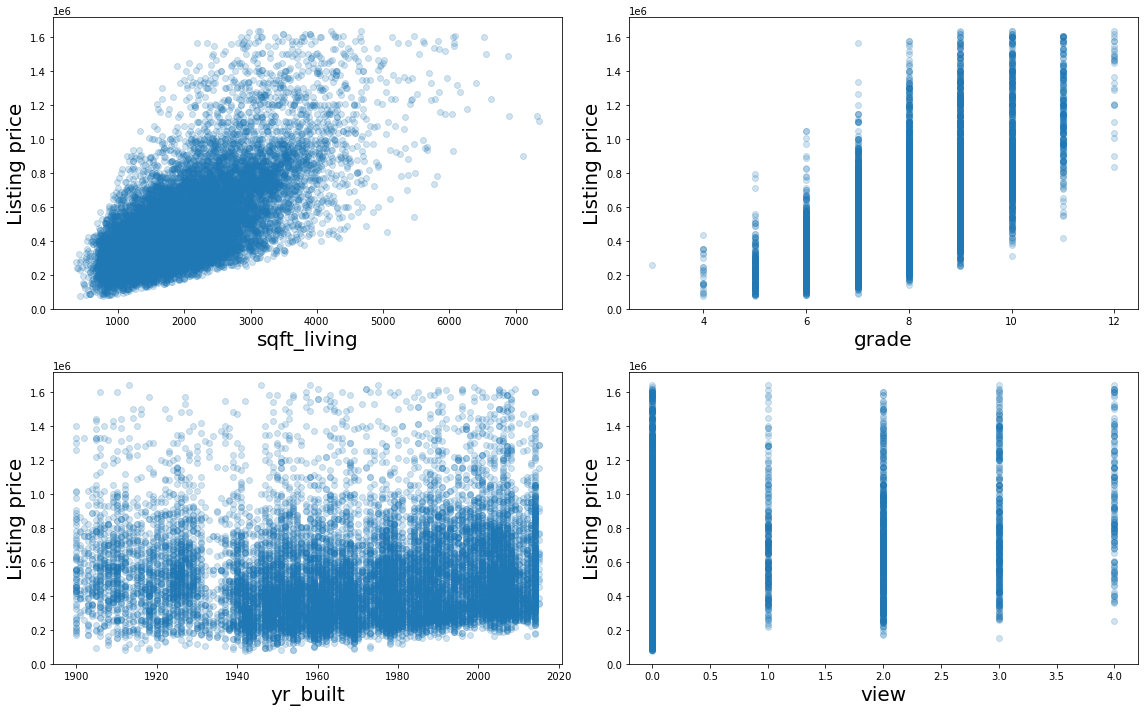

In [89]:
# Linearity
linearity_plot(amazing_X_train[['sqft_living', 'grade', 'yr_built', 'view']], amazing_y_train)

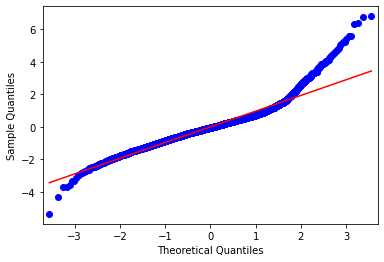

In [90]:
#NORMALITY
amazing_X_test_scaled = pd.DataFrame(amazing_X_test_scaled)
preds_amazing = amazing_model.predict(amazing_X_test_scaled)
residuals = (amazing_y_test - preds_amazing)
sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True);

In [91]:
#Checking MULTICOLLINEARITY 
# (VIF NEEDS TO BE <5 ALL CATEGORIES)
vif = [variance_inflation_factor(amazing_X_train_scaled.values, i) for i in range(amazing_X_train_scaled.shape[1])]
pd.Series(vif, index=amazing_X_train_scaled.columns, name="Variance Inflation Factor")

sqft_living                   2.355158
District_BELLEVUE             2.556232
District_ENUMCLAW             1.397905
District_FEDERAL_WAY          2.653295
District_HIGHLINE             2.545407
District_ISSAQUAH             3.169895
District_KENT                 2.965916
District_LAKE_WASHINGTON      3.908868
District_MERCER_ISLAND        1.405512
District_NORTHSHORE           2.328468
District_RENTON               2.672803
District_RIVERVIEW            1.438773
District_SEATTLE              7.872637
District_SHORELINE            2.195310
District_SKYKOMISH            1.020002
District_SNOQUALMIE_VALLEY    1.837130
District_TAHOMA               1.852017
District_TUKWILA              1.150148
District_VASHON_ISLAND        1.164963
grade                         2.806034
yr_built                      1.676259
view                          1.121240
Name: Variance Inflation Factor, dtype: float64

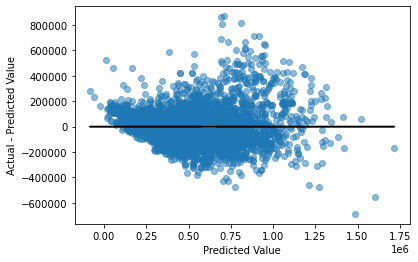

In [92]:
#HOMOSCEDASTICITY
fig, ax = plt.subplots()

ax.scatter(preds_amazing, residuals, alpha=0.5)
ax.plot(preds_amazing, [0 for i in range(len(amazing_X_test_scaled))], color='black')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

774900.0
Price of sample: $774900.0


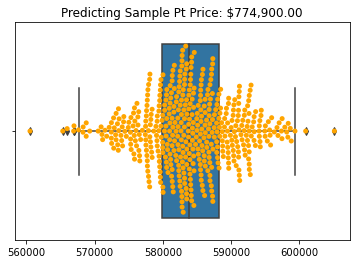

In [93]:
test_box(amazing_full_formula)

# Regression Results - Great Model

We decided to use Great Model as our Final model. This model did very well with 3 predictors. Those predictors are square feet living, school district, and grade. The reasoning for selecting Great Model even though some of the following models had higher R-squared values was because it was simple, yet understandable. The following models seemed to muddy the waters when it came to the linearity assumption. 

The Great Model is able to explain 72.3% of the variance in price of King County Home Sales in 2014-15 with just 3 predictors.
This is a good R-squared value as it is above the 70% threshold. The model had a Train RMSE of 137070.49516065692 and a Test RMSE of 136447.31048874996. These are very close to each other, meaning the fit of the model is not underfit or overfit.

The Great Model does a great job at helping our stakeholder, the real estate agency, understand the gist of what drives home prices in the King County area. More specifically, it gives invaluable information about which school district they should target for either top end or bottom end location values.

In [94]:
sm.OLS(great_y_train, sm.add_constant(great_X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     2076.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        00:03:41   Log-Likelihood:            -2.1143e+05
No. Observations:               15960   AIC:                         4.229e+05
Df Residuals:                   15939   BIC:                         4.231e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -4.987e+05   1.07e+04    -46.583      0.000    -5.2e+05   -4.78e+05
sqft_living                  134.4543      1.957     68.696      0.000     130.618     138.291
District_BELLEVUE           3.601e+05   7780.478     46.282      0.000    3.45e+05    3.75e+05
District_ENUMCLAW           6.508e+04   1.14e+04      5.724      0.000    4.28e+04    8.74e+04
District_FEDERAL_WAY       -3235.9033   7622.382     -0.425      0.671   -1.82e+04    1.17e+04
District_HIGHLINE           9.863e+04   7782.911     12.673      0.000    8.34e+04    1.14e+05
District_ISSAQUAH           2.032e+05   7422.089     27.372      0.000    1.89e+05    2.18e+05
District_KENT               1.824e+04   7385.171      2.469      0.014    3761.031    3.27e+04
District_LAKE_WASHINGTON    2.378e+05   7018.643     33.887      0.000    2.24e+05    2.52e+05
District_MERCER_ISLAND      5.088e+05   1.17e+04     43.543      0.000    4.86e+05    5.32e+05
District_NORTHSHORE         1.537e+05   8000.399     19.216      0.000    1.38e+05    1.69e+05
District_RENTON             9.294e+04   7611.474     12.210      0.000     7.8e+04    1.08e+05
District_RIVERVIEW          1.211e+05   1.09e+04     11.087      0.000    9.97e+04    1.43e+05
District_SEATTLE            2.974e+05   6427.145     46.273      0.000    2.85e+05     3.1e+05
District_SHORELINE          1.625e+05   8193.371     19.831      0.000    1.46e+05    1.79e+05
District_SKYKOMISH          9.281e+04   4.38e+04      2.118      0.034    6928.252    1.79e+05
District_SNOQUALMIE_VALLEY   1.26e+05   8941.986     14.092      0.000    1.08e+05    1.44e+05
District_TAHOMA             4.614e+04   8899.406      5.185      0.000    2.87e+04    6.36e+04
District_TUKWILA            4.293e+04   1.69e+04      2.541      0.011    9812.714     7.6e+04
District_VASHON_ISLAND      2.087e+05   1.63e+04     12.777      0.000    1.77e+05    2.41e+05
grade                       7.109e+04   1492.201     47.641      0.000    6.82e+04     7.4e+04
==============================================================================
Omnibus:                     4227.521   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17655.118
Skew:                           1.252   Prob(JB):                         0.00
Kurtosis:                       7.504   Cond. No.                     8.91e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [95]:
print(f'Train RMSE: {mean_squared_error(great_y_train, great_model.predict(great_X_train_scaled), squared=False)}')
print(f'Test RMSE: {mean_squared_error(great_y_test, great_model.predict(great_X_test_scaled), squared=False)}')

Train RMSE: 137070.49516065692
Test RMSE: 136447.31048874996


# Conclusion

Our model showed us that the most important predictors to look at in a home are going to be square feet living, school district, and building grade. To relate this back to our stakeholder, we want to inform the real estate agency to focus on these elements in their deals. We can also help them by allowing them to plot different values in our model and giving them a rough valuation based on these variables.

Our model separates each home into 3 basic elements that contribute to value:
1. Home size & usable space (sqft_living)
2. Location (school district)
3. Upgrades, amenities, & design elements (grade)

To improve our model in the future, we could bin house sales by neighborhood. We could then compare home sales within individual neighborhood and model what features accounted for the discrepancies in sales price. This would give us a more detailed look at what features distinguish home valuations. This would also help the stakeholder with their offers and listings in a more detailed and refined level. More data would also be very useful. Another thing we could improve on is using more location metrics. The location metrics we would want to add include proximity to shopping, amenities, entertainment, recreation, airports, parks, schools, landmarks, tourist attractions, and employment opportunities. 